In [228]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
import tensorflow as tf
import datetime
from sklearn import linear_model

In [135]:
# Generate sample
# y = a1 * x1 + a2 * x2 + eps
numObs = 20000
rndSmpl = np.random.normal(0, 1, [3, numObs])
#print(rndSmpl)
cutoff = 0
beta = np.array([[1.9, -1.7, 2.3]]).transpose()
x = np.vstack([np.ones((1, numObs)), rndSmpl[0:2, :]])
eps = rndSmpl[2, :]

y_n = np.matmul(beta.transpose(), x) + eps*8
y = (y_n > cutoff) * 1.0

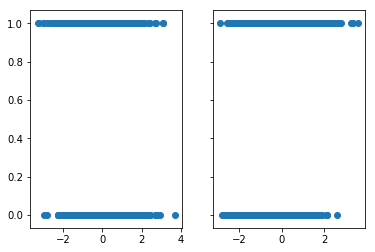

In [110]:
#Plot sample

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(x[1,:], y)
ax2.scatter(x[2,:], y)

In [136]:
skLR = linear_model.LogisticRegression()
skLR.fit(x.transpose(), y.transpose())

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [137]:
skLR.coef_

array([[ 0.19295046, -0.33731   ,  0.4435699 ]])

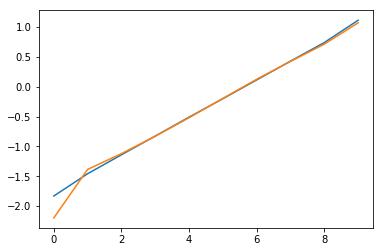

In [139]:
def plot_logodds(y_act, y_logodds, num=10):
    y_lo_rng = np.percentile(y_logodds, [1, 99])
    y_lo_ls = np.linspace(y_lo_rng[0], y_lo_rng[1], num-1)

    yg = []
    for i in range(-1,len(y_lo_ls)):
        e_left = -np.Inf
        e_right = np.Inf
        if(i >= 0):
            e_left = y_lo_ls[i]
        if(i+1 < len(y_lo_ls)):
            e_right = y_lo_ls[i+1]
        t_est = np.mean(y_logodds[(y_logodds >= e_left)*(y_logodds <= e_right)])
        t_act_p = np.mean(y_act[0,(y_logodds >= e_left)*(y_logodds <= e_right)])
        t_act = -np.log(t_act_p / (1 - t_act_p))
        yg = yg + [[t_est, t_act, np.sum((y_logodds >= e_left)*(y_logodds <= e_right))]]
    ya = np.array(yg)
    plt.plot(ya[:,0])
    plt.plot(ya[:,1])
    

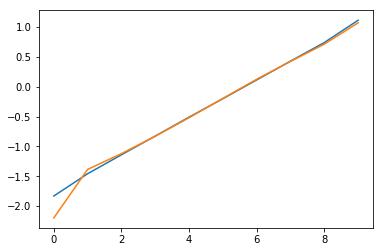

In [140]:
y_pred = skLR.predict_log_proba(x.transpose())
y_lo = y_pred[:,0]-y_pred[:,1]
plot_logodds(y, y_lo)

In [160]:
#Manual TensorFlow calculation: graph creation
tf.reset_default_graph()
tf_X = tf.constant(x, dtype=tf.float32)
tf_y = tf.constant(y, dtype=tf.float32)
tf_n = tf.constant(y.shape[1], dtype=tf.float32)
tf_b = tf.Variable(np.zeros(beta.shape), dtype=tf.float32)
tf_lr = tf.Variable(1e-1, dtype=tf.float32)
tf_bTX = tf.matmul(tf.transpose(tf_b), tf_X)
tf_p = 1.0 / (1.0 + tf.exp(tf_bTX))
tf_grad = tf.matmul(tf_X, tf.transpose(tf_y - tf_p)) / tf_n
tf_eps = tf.sqrt(tf.matmul(tf.transpose(tf_grad), tf_grad))
tf_train = tf.assign(tf_b, tf_b - tf_lr * tf_grad)

In [163]:
#Manual TensorFlow calculation: execution

with tf.Session() as sess:
    tf_b.initializer.run()
    tf_lr.initializer.run()
    for n in range(20):
        for i in range(100):
            tf_train.eval()
      #  print(tf_b.eval())
      #  print(tf_eps.eval())
    mantf_beta = tf_b.eval()
    mantf_ylo = tf_bTX.eval()
    print(mantf_beta)    

[[-0.38595527]
 [ 0.33739364]
 [-0.44368857]]


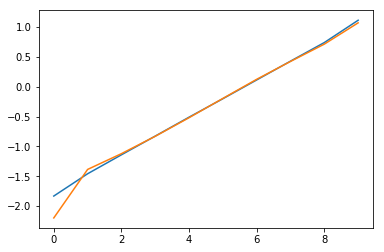

In [173]:
#Manual TensorFlow calculation: validation

plot_logodds(y, np.reshape(mantf_ylo, mantf_ylo.shape[1]))

In [196]:
#Autodiff TensorFlow calculation: graph creation
tf.reset_default_graph()
tf_X = tf.constant(x, dtype=tf.float32)
tf_y = tf.constant(y, dtype=tf.float32)
tf_n = tf.constant(y.shape[1], dtype=tf.float32)
tf_b = tf.Variable(np.zeros(beta.shape), dtype=tf.float32)
tf_lr = tf.Variable(1e-1, dtype=tf.float32)
tf_bTX = tf.matmul(tf.transpose(tf_b), tf_X)
tf_errf = -(tf.matmul(tf_y, tf.transpose(tf_bTX)) - tf.reduce_sum(tf.log(1 + tf.exp(tf_bTX)))) / tf_n
tf_grad = tf.gradients(tf_errf, [tf_b])[0]
tf_eps = tf.sqrt(tf.matmul(tf.transpose(tf_grad), tf_grad))
tf_train = tf.assign(tf_b, tf_b - tf_lr * tf_grad)

In [199]:
with tf.Session() as sess:
    tf_b.initializer.run()
    tf_lr.initializer.run()
    for n in range(20):
        for i in range(100):
            tf_train.eval()
        #print(tf_b.eval())
        #print(tf_eps.eval())
    autotf_beta = -tf_b.eval()
    autotf_ylo = -tf_bTX.eval()
    print(autotf_beta)    

[[-0.38595533]
 [ 0.33739367]
 [-0.44368851]]


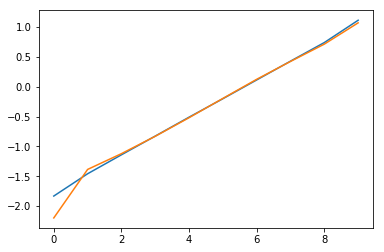

In [200]:
#Autodiff TensorFlow calculation: validation

plot_logodds(y, np.reshape(autotf_ylo, autotf_ylo.shape[1]))

In [238]:
#Auto TensorFlow calculation: graph creation
tf.reset_default_graph()
tf_X = tf.constant(x, dtype=tf.float32)
tf_y = tf.constant(y, dtype=tf.float32)
tf_n = tf.constant(y.shape[1], dtype=tf.float32)
tf_b = tf.Variable(np.zeros(beta.shape), dtype=tf.float32)
tf_bTX = tf.matmul(tf.transpose(tf_b), tf_X)
tf_errf = (tf.matmul(tf_y, tf.transpose(tf_bTX)) + tf.reduce_sum(tf.log(1 + tf.exp(-tf_bTX)))) / tf_n
tf_optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-1)
tf_train = tf_optimizer.minimize(tf_errf)

dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
log_dir = 'D:/Jupyter/Logs/' + dt_now
tf.summary.FileWriter(log_dir, tf.get_default_graph())

In [226]:
with tf.Session() as sess:
    tf_b.initializer.run()
    for i in range(1000):
        tf_train.run()
    atf_beta = tf_b.eval()
    atf_ylo = tf_bTX.eval()
    print(atf_beta) 

[[-0.38595533]
 [ 0.33739367]
 [-0.44368851]]


In [237]:
dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")

'2017-08-16_195851'